#  Определение частей речи с использованием рекуррентных нейронных сетей

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann
* https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html
* https://notebook.community/sameersingh/uci-statnlp/tutorials/rnn_examples
* https://github.com/bentrevett/pytorch-pos-tagging/blob/master/1_bilstm.ipynb
* https://github.com/Koziev/rupostagger

## Задачи для совместного разбора

1\. Рассмотрите пример работы двунаправленного рекуррентого слоя

![bi-lstm](https://discuss.pytorch.org/uploads/default/original/3X/d/3/d34a27c490e75c1a0a96128c5726ab6656427d90.jpeg)

In [ ]:
import torch as th
import torch.nn as nn

In [ ]:
batch_size = 16
seq_len = 5
emb_dim = 32
x = th.rand(batch_size, seq_len, emb_dim)

hidden_size = 15
lstm = nn.LSTM(input_size=emb_dim, hidden_size=hidden_size, batch_first=True, bidirectional=True)

In [ ]:
o, (h, c) = lstm(x)

In [ ]:
o.shape, h.shape, c.shape

(torch.Size([16, 5, 30]), torch.Size([2, 16, 15]), torch.Size([2, 16, 15]))

2\. Рассмотрите пример работы многоуровневого рекуррентого слоя

![stacked-rnn](https://lh6.googleusercontent.com/rC1DSgjlmobtRxMPFi14hkMdDqSkEkuOX7EW_QrLFSymjasIM95Za2Wf-VwSC1Tq1sjJlOPLJ92q7PTKJh2hjBoXQawM6MQC27east67GFDklTalljlt0cFLZnPMdhp8erzO)

In [ ]:
lstm = nn.LSTM(input_size=emb_dim, hidden_size=hidden_size, batch_first=True, num_layers=3)

In [ ]:
o, (h, c) = lstm(x)

In [ ]:
o.shape, h.shape, c.shape

(torch.Size([16, 5, 15]), torch.Size([3, 16, 15]), torch.Size([3, 16, 15]))

## Задачи для самостоятельного решения

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchmetrics

In [3]:
import torch as th
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader
import torchtext.transforms as T
import torchmetrics as M
import re
import pandas as pd
from torchtext.vocab import build_vocab_from_iterator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

<p class="task" id="1"></p>

1\. Считайте файл `pos_data.txt` и создайте на его основе два списка `X` и `y` следующего вида.

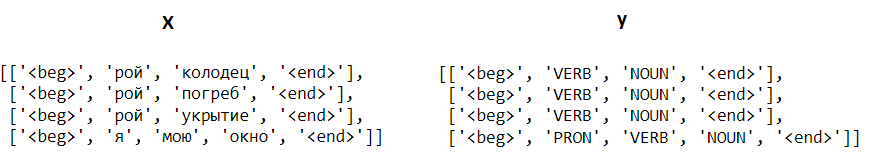

Найдите 75% квантиль распределения длин предложений и удалите из выборки те предложения, которые длиннее данного значения. Выведите на экран пару `(X[0], y[0])` и количество элементов в `X` и `y`.

- [ ] Проверено на семинаре

In [4]:
with open('/content/drive/MyDrive/данные/pos_data.txt', 'r', encoding='utf-8') as fp:
  X = []
  Y = []
  for line in fp.readlines():
    if '<beg>' in line:
      x = ['<beg>']
      y = ['<beg>']
    elif '<end>' in line:
      x.append('<end>')
      y.append('<end>')
      X.append(x)
      Y.append(y)
    else:
      try:
        word, pos = line.split('\t')[1:3]
        pos = re.findall(r'\w+', pos)[0]
        x.append(word)
        y.append(pos)
      except ValueError:
        pass

len(X), len(Y)

(990066, 990066)

In [5]:
df = pd.DataFrame({'x': X, 'y': Y})
df['len'] = df['x'].apply(lambda x: len(x))
ind = df[df['len'] > df['len'].quantile(0.75)].index
df.drop(index=ind, inplace=True)

In [6]:
X = list(df['x'].values)
Y = list(df['y'].values)
len(X), len(Y)

(776002, 776002)

In [7]:
X[0], Y[0]

(['<beg>', 'рой', 'колодец', '<end>'], ['<beg>', 'VERB', 'NOUN', '<end>'])

<p class="task" id="2"></p>

2\. Разделите данные на обучающую и тестовую выборку. Создайте два Vocab на основе загруженных данных: `vocab_X` для слов и `vocab_y` для частей речи. Добавьте в словари специальные токены `<PAD>`, `<UNK>`, `<beg>`, `<end>`. Выведите на экран количество токенов в полученных словарях.

- [ ] Проверено на семинаре

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
len(X_train), len(X_test)

(620801, 155201)

In [9]:
vocab_x = build_vocab_from_iterator(X_train, specials=['<PAD>', '<UNK>', '<beg>', '<end>'])
vocab_y = build_vocab_from_iterator(y_train, specials=['<PAD>', '<UNK>', '<beg>', '<end>'])
vocab_x.set_default_index(vocab_x['<UNK>'])
vocab_y.set_default_index(vocab_y['<UNK>'])
len(vocab_x), len(vocab_y)

(212079, 20)

<p class="task" id="3"></p>

3\. Создайте класс `POSTaggingDataset`. Реализуйте `__getitem__` таким образом, чтобы он возвращал кортеж `(x, y)`, где x - это набор индексов токенов для предложений на русском языке, а `y` - набор индексов токенов для соответствующих частей речи. Используя преобразования, сделайте длины наборов индексов одинаковой фиксированной длины. Создайте два датасета: для обучающей и тестовой выборки.

Выведите на экран формы тензоров `x` и `y`:

```python
x, y = train_dset[:5]
print(x.shape, y.shape)
```



- [ ] Проверено на семинаре

In [10]:
class POSTaggingDataset:
  def __init__(self, x, y, transforms_x, transforms_y):
    self.x = x
    self.y = y
    self.transform_x = transforms_x
    self.transform_y = transforms_y

  def __getitem__(self, idx):
    return self.transform_x(self.x[idx]), self.transform_y(self.y[idx])

  def __len__(self):
    return len(self.x)

In [11]:
transfroms_X = T.Sequential(
    T.VocabTransform(vocab_x),
    T.ToTensor(0),
    T.PadTransform(25, pad_value=0)
)
transfroms_Y = T.Sequential(
    T.VocabTransform(vocab_y),
    T.ToTensor(0),
    T.PadTransform(25, pad_value=0)
)
dataset_train = POSTaggingDataset(X_train, y_train, transfroms_X, transfroms_Y)
dataset_test = POSTaggingDataset(X_test, y_test, transfroms_X, transfroms_Y)

In [12]:
train_loader = DataLoader(dataset_train, batch_size=128)
test_loader = DataLoader(dataset_test, batch_size=128)

In [13]:
x, y = dataset_train[:5]
x.shape, y.shape

(torch.Size([5, 25]), torch.Size([5, 25]))

<p class="task" id="4"></p>

4\. Создайте и обучите модель для предсказания частей речи. Игнорируйте токен `<PAD>` при расчете ошибки. Во время обучения выводите на экран значения функции потерь для эпохи, значение accuracy для эпохи.

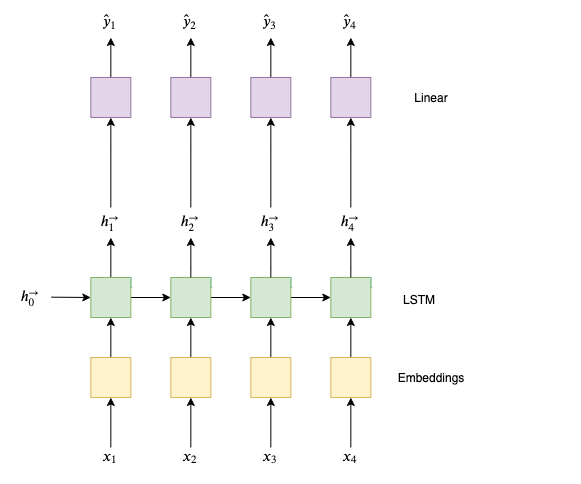

- [ ] Проверено на семинаре

In [14]:
class Model(nn.Module):
  def __init__(self, vcb, emb_dim, hidden_size, out_features):
    super().__init__()
    self.hidden_size = hidden_size
    self.emb = nn.Embedding(num_embeddings=len(vcb), embedding_dim=emb_dim, padding_idx=0)
    self.lstm = nn.LSTM(input_size=emb_dim, hidden_size=hidden_size, batch_first=True)
    self.fc = nn.Linear(in_features=hidden_size, out_features=out_features)

  def forward(self, X):
    emb_X = self.emb(X)
    out, (h, c) = self.lstm(emb_X)
    out = self.fc(out).permute(0, 2, 1)
    return out

In [15]:
n_epoch = 5
lr = 0.001
model = Model(vocab_x, emb_dim=100, hidden_size=100, out_features=len(vocab_y))
model.to(device='cuda')
optimizer = optim.Adam(model.parameters(), lr=lr)
crit = nn.CrossEntropyLoss(ignore_index=0)

for epoch in range(1, n_epoch+1):
  acc = M.Accuracy(task="multiclass", num_classes=len(vocab_y), ignore_index=0)
  for X_b, y_b in train_loader:
    out = model(X_b.to(device='cuda'))
    loss = crit(out, y_b.to(device='cuda'))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    acc.update(out.to(device='cpu'), y_b)
  print(f'{epoch=} loss={loss.item()} acc={acc.compute()}')

epoch=1 loss=0.021344883367419243 acc=0.9126924276351929
epoch=2 loss=0.011620520614087582 acc=0.9721678495407104
epoch=3 loss=0.011811533942818642 acc=0.9824903607368469
epoch=4 loss=0.011740261688828468 acc=0.9870165586471558
epoch=5 loss=0.010069135576486588 acc=0.9893836379051208


<p class="task" id="5"></p>

5\. Постройте и выведите на экран classification report на основе тестовой выборки. Выведите на экран пример предсказания частей речи обученной моделью.

- [ ] Проверено на семинаре

In [18]:
def report(loader):
  preds = []
  true = []
  for X_b, y_b in loader:
    out = model(X_b.to(device='cuda'))
    preds.extend(th.argmax(out.to(device='cpu'), dim=1).detach().numpy().flatten())
    true.extend(y_b.numpy().flatten())
  print(classification_report(true, preds, target_names=vocab_y.get_itos()[1:], zero_division=0))

In [19]:
report(test_loader)

              precision    recall  f1-score   support

       <UNK>       0.00      0.00      0.00   2658826
       <beg>       1.00      1.00      1.00    155201
       <end>       0.54      1.00      0.70    155201
        NOUN       0.07      0.96      0.13    200174
       PUNCT       1.00      1.00      1.00    174036
        VERB       0.99      0.97      0.98    174024
         ADJ       0.75      0.95      0.84     91304
        PRON       0.97      0.98      0.98     86819
         ADP       1.00      0.99      0.99     61599
         ADV       0.95      0.96      0.95     57898
        CONJ       0.94      0.95      0.95     29056
        PART       0.95      0.90      0.92     26548
         NUM       0.98      0.87      0.92      6455
           X       0.73      0.22      0.34      1105
        LATN       0.40      0.49      0.44       551
           H       0.66      0.31      0.42       435
         DET       0.25      0.22      0.24       421
        INTJ       0.72    

In [20]:
x, y = next(iter(test_loader))
x = x[0]
y = y[0]
x = x[x > 0]
y = y[y > 0]
x, y

(tensor([    2,   180,     8, 33253,     4,     3]),
 tensor([ 2, 10, 12,  6,  5,  3]))

In [21]:
vocab_x.lookup_tokens(x[x > 0].tolist()), vocab_y.lookup_tokens(y[y > 0].tolist())

(['<beg>', 'пока', 'не', 'надоест', '.', '<end>'],
 ['<beg>', 'ADV', 'PART', 'VERB', 'PUNCT', '<end>'])

In [22]:
out = model(x.view(-1, x.shape[0]).to(device='cuda'))
out = th.argmax(out, dim=1).tolist()[0]
out

[2, 10, 12, 6, 5, 3]

In [23]:
print(vocab_y.lookup_tokens(out))

['<beg>', 'ADV', 'PART', 'VERB', 'PUNCT', '<end>']


<p class="task" id="6"></p>

6\. Решите задачи 4-5, используя двунаправленный рекуррентный слой.

![biLSTM](https://camo.githubusercontent.com/9bc90608fecf249e80f0ec0053469e91ff6347922aa136fda5bbec3de8303862/68747470733a2f2f6769746875622e636f6d2f62656e747265766574742f7079746f7263682d706f732d74616767696e672f626c6f622f6d61737465722f6173736574732f706f732d6269646972656374696f6e616c2d6c73746d2e706e673f7261773d31)

- [ ] Проверено на семинаре

In [25]:
class ModelBidirectional(nn.Module):
  def __init__(self, vcb, emb_dim, hidden_size, n_layers, bidir, out_features):
    super().__init__()
    self.hidden_size = hidden_size
    self.emb = nn.Embedding(num_embeddings=len(vcb), embedding_dim=emb_dim, padding_idx=0)
    self.lstm = nn.LSTM(input_size=emb_dim, hidden_size=hidden_size,
                        num_layers=n_layers, bidirectional=bidir, batch_first=True)
    self.fc = nn.Linear(in_features=hidden_size*2, out_features=out_features)

  def forward(self, X):
    emb_X = self.emb(X)
    out, (h, c) = self.lstm(emb_X)
    out = self.fc(out).permute(0, 2, 1)
    return out

In [27]:
n_epoch = 5
lr = 0.001
model = ModelBidirectional(vocab_x, emb_dim=100, hidden_size=50,
              n_layers=1, bidir=True, out_features=len(vocab_y))
model.to(device='cuda')
optimizer = optim.Adam(model.parameters(), lr=lr)
crit = nn.CrossEntropyLoss(ignore_index=0)

for epoch in range(1, n_epoch+1):
  acc = M.Accuracy(task="multiclass", num_classes=len(vocab_y), ignore_index=0)
  for X_b, y_b in train_loader:
    out = model(X_b.to(device='cuda'))
    loss = crit(out, y_b.to(device='cuda'))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    acc.update(out.to(device='cpu'), y_b)
  print(f'{epoch=} loss={loss.item()} acc={acc.compute()}')

epoch=1 loss=0.04724935069680214 acc=0.9223761558532715
epoch=2 loss=0.013014499098062515 acc=0.9777881503105164
epoch=3 loss=0.007607594132423401 acc=0.9868016839027405
epoch=4 loss=0.006604829803109169 acc=0.9908450841903687
epoch=5 loss=0.0032288371585309505 acc=0.9931533932685852


In [28]:
report(test_loader)

              precision    recall  f1-score   support

       <UNK>       0.00      0.00      0.00   2658826
       <beg>       1.00      1.00      1.00    155201
       <end>       1.00      1.00      1.00    155201
        NOUN       0.25      0.95      0.39    200174
       PUNCT       1.00      1.00      1.00    174036
        VERB       0.98      0.98      0.98    174024
         ADJ       0.05      0.97      0.09     91304
        PRON       0.99      0.98      0.99     86819
         ADP       1.00      1.00      1.00     61599
         ADV       0.96      0.96      0.96     57898
        CONJ       0.96      0.96      0.96     29056
        PART       0.95      0.93      0.94     26548
         NUM       0.97      0.88      0.92      6455
           X       0.64      0.31      0.42      1105
        LATN       0.00      0.49      0.00       551
           H       0.70      0.43      0.53       435
         DET       0.36      0.40      0.38       421
        INTJ       0.79    

In [29]:
x, y = next(iter(test_loader))
x = x[0]
y = y[0]
x = x[x > 0]
y = y[y > 0]
x, y

(tensor([    2,   180,     8, 33253,     4,     3]),
 tensor([ 2, 10, 12,  6,  5,  3]))

In [30]:
vocab_x.lookup_tokens(x.tolist()), vocab_y.lookup_tokens(y.tolist())

(['<beg>', 'пока', 'не', 'надоест', '.', '<end>'],
 ['<beg>', 'ADV', 'PART', 'VERB', 'PUNCT', '<end>'])

In [31]:
out = model(x.view(-1, x.shape[0]).to(device='cuda'))
out = th.argmax(out, dim=1).tolist()[0]
out

[2, 10, 12, 6, 5, 3]

In [32]:
print(vocab_y.lookup_tokens(out))

['<beg>', 'ADV', 'PART', 'VERB', 'PUNCT', '<end>']


## Обратная связь
- [x] Хочу получить обратную связь по решению